In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

from helper_funcs import *

In [2]:
zipdata = get_modelzip()
zipdata.shape

----pulling ZipCode data from Azure storage----
----Done----


(6987, 20)

In [3]:
zipdata.isna().sum()

Population              0
Blacks_ratio            0
Hispanics_ratio         0
Asians_ratio            0
Indians_ratio           0
Others_ratio            0
Male_ratio              0
HouseholdsPerZipCode    0
MedianAge               0
school_rating           0
over_65_ratio           0
IncomePerHousehold      0
NumberOfBusinesses      0
UE_rate                 0
HPI                     0
Demand_score            0
Supply_score            0
listviews_vs_US         0
med_days_on_mkt         0
nielson_rank            0
dtype: int64

In [4]:
mms = MinMaxScaler()
# REMOVE AverageHouseValue
data_scaled = pd.DataFrame(mms.fit_transform(zipdata.values), 
                           columns=zipdata.columns, 
                           index=zipdata.index)

In [9]:
pca = PCA(n_components=0.85)
pca.fit(data_scaled)
print(f'population PCA explained: {np.round(pca.explained_variance_ratio_,3)}')
print(f'number of PCA columns: {len(pca.explained_variance_ratio_)}')
all_PCAs = pd.DataFrame(pca.fit_transform(data_scaled), 
                        columns=['PCA_'+str(n) for n in range(len(pca.explained_variance_ratio_))], 
                        index=zipdata.index)
all_PCAs = all_PCAs.merge(zipdata, how = 'left', left_index=True, right_index=True)

population PCA explained: [0.464 0.174 0.104 0.057 0.046 0.041]
number of PCA columns: 6


In [10]:
RF = get_redfin_csv()
print(RF.shape)

----pulling Redfin data from Azure storage----
----Done----
(74717, 21)


In [11]:
RF = RF.merge(all_PCAs, how = 'left', left_on = 'zip', right_index=True)

In [12]:
#pd.set_option('display.max_rows', None)
zip_houses = RF.groupby('zip').agg('count')['PRICE'].to_dict()
RF['houses_perZIP'] = RF.zip.apply(lambda r: zip_houses[r])
RF = RF[RF.houses_perZIP>4]
# Use groupby to split the df into smaller dfs for each ZIP
groups = RF.groupby('zip')
dfs = [groups.get_group(x) for x in groups.groups]
# Use first df to initiate X_train, X_test, etc
for d in dfs[:1]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip',
              'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3','PCA_4', 'school_rating']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_train, X_test, y_train, y_test = train_test_split(feat, y, test_size=0.25)
# train_test_split each df then stack together
for d in dfs[1:]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip',
              'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3','PCA_4', 'school_rating']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_trainpiece, X_testpiece, y_trainpiece, y_testpiece = train_test_split(feat, y, test_size=0.25)
    X_train = X_train.append(X_trainpiece)
    X_test = X_test.append(X_testpiece)
    y_train = y_train.append(y_trainpiece)
    y_test = y_test.append(y_testpiece)
# Check rows
print(f'X_train rows: {X_train.shape}')
print(f'X_test rows: {X_test.shape}')

X_train rows: (54473, 13)
X_test rows: (19083, 13)


In [13]:
X_train.Prop_Type.value_counts()

Single Family Residential    36155
Condo/Co-op                  11707
Townhouse                     5556
Multi-Family (2-4 Unit)        888
Ranch                          131
Multi-Family (5+ Unit)          36
Name: Prop_Type, dtype: int64

In [14]:
prop_encode = {'Single Family Residential':0,
               'Condo/Co-op':1,
               'Townhouse':2,
               'Multi-Family (2-4 Unit)':3,
               'Ranch':4,
               'Multi-Family (5+ Unit)':5}
X_train['Prop_Type'] = X_train.Prop_Type.apply(lambda x: prop_encode[x])
X_test['Prop_Type'] = X_test.Prop_Type.apply(lambda x: prop_encode[x])

In [15]:
zip_encode = LabelEncoder()
zip_encode.fit(X_train['zip'])
X_train['zip'] = zip_encode.transform(X_train['zip'])
X_test['zip'] = zip_encode.transform(X_test['zip'])

In [16]:
cat = CatBoostRegressor(verbose=False)
cat.fit(X_train, y_train)
print(f'Train R2: {cat.score(X_train, y_train)}')
print(f'Test R2: {cat.score(X_test, y_test)}')

Train R2: 0.8721776288296046
Test R2: 0.8420393698454299


In [17]:
y_pred= cat.predict(X_test)
#RMSE
print(np.sqrt(mean_squared_error(y_test,y_pred)))

0.13700389873047272


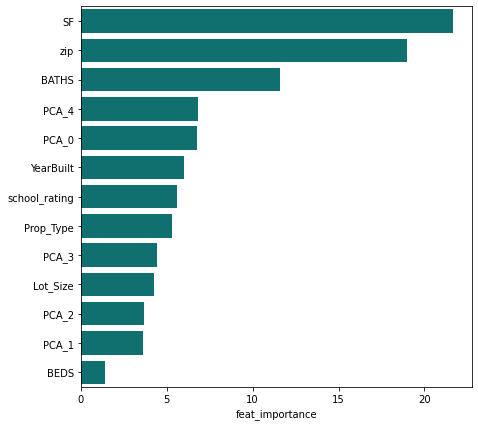

In [18]:
feat_importances = pd.DataFrame(cat.get_feature_importance(), index=X_train.columns, columns=['feat_importance'])
feat_importances = feat_importances.sort_values(by='feat_importance', ascending=False)

f, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x='feat_importance', y=feat_importances.index, data=feat_importances, color="teal");

### Retrain on full dataset

In [19]:
X_full = RF[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip',
             'PCA_0','PCA_1', 'PCA_2', 'PCA_3','PCA_4', 'school_rating']]
y = np.log10(RF.PRICE)
X_full['Prop_Type'] = X_full.Prop_Type.apply(lambda x: prop_encode[x])
zip_encode = LabelEncoder()
zip_encode.fit(X_full['zip'])
X_full['zip'] = zip_encode.transform(X_full['zip'])

In [20]:
cat = CatBoostRegressor(verbose=False)
cat.fit(X_full, y)
print(f'R2: {cat.score(X_full, y)}')

R2: 0.8691022509664942


### Pickle it 🥒

In [21]:
import pickle
pickle.dump(cat, open('SMH_model.pkl', 'wb'))
pickle.dump(zip_encode, open('zip_encoder.pkl', 'wb'))

### Taste it 🥒

In [22]:
pickled_model = pickle.load(open('SMH_model.pkl', 'rb'))
zip_encoder = pickle.load(open('zip_encoder.pkl', 'rb'))

In [24]:
X_pred = RF[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip',
             'PCA_0','PCA_1', 'PCA_2', 'PCA_3','PCA_4', 'school_rating']].iloc[0,:]

In [27]:
prop_encode = {'Single Family Residential':0,
               'Condo/Co-op':1,
               'Townhouse':2,
               'Multi-Family (2-4 Unit)':3,
               'Ranch':4,
               'Multi-Family (5+ Unit)':5}
X_pred['Prop_Type'] = prop_encode[X_pred['Prop_Type']]

In [33]:
X_pred['zip'] = zip_encoder.transform(X_pred[['zip']])

In [34]:
print(f'predicted: {10**pickled_model.predict(X_pred)}')
print(f'true y: {10**y[0]}')

predicted: 937398.6329205453
true y: 899900.0000000003
